In [242]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
import warnings
warnings.filterwarnings('ignore')

### Задание 1
Сформируйте посредством sklearn.make_classification датасет из 100 объектов с двумя признаками. Обучите случайный лес из 1, 3, 10 и 50 деревьев и визуализируйте их разделяющие гиперплоскости на графиках по подобию визуализации деревьев из предыдущего урока, заменив вызов функции predict на tree_vote.

In [243]:
# Генерация данных
classification_data, classification_labels = make_classification(n_samples=100,
                                                                n_features=2, n_informative=2,
                                                                n_classes=2, n_redundant=0,
                                                                n_clusters_per_class=1, random_state=23)

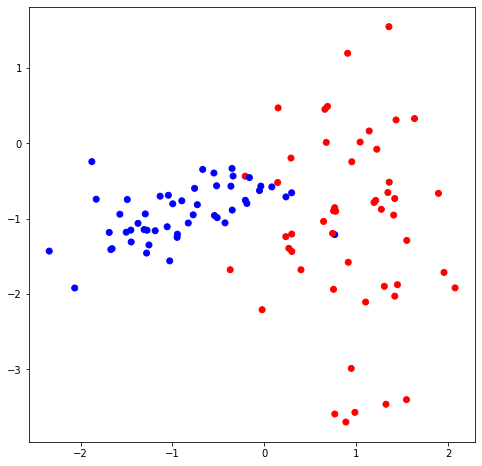

In [244]:
# визуализация сгенерированных данных
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])
plt.figure(figsize=(8,8))
plt.scatter(classification_data[:,0], classification_data[:, 1], c=classification_labels, cmap=colors)
plt.show()

In [245]:
# генерация N бутстрап-выборок и подмножества признаков
np.random.seed(42)
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] #совпадает с исходной выборкой
    bootstrap = []
    
    for i in range(N):
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        bootstrap.append((b_data, b_labels))
    return bootstrap

In [246]:
get_bootstrap(classification_data, classification_labels, 2)

[(array([[-0.37124564, -1.67679697],
         [-0.51278018, -0.98556015],
         [-0.54813278, -0.39241207],
         [-0.94885569, -1.24713565],
         [ 0.1502772 ,  0.47273166],
         [ 0.39895961, -1.67752215],
         [ 2.07599128, -1.91770526],
         [ 0.7432376 , -1.19378765],
         [ 1.63478531,  0.33127428],
         [ 1.63478531,  0.33127428],
         [ 0.2357014 , -0.70960755],
         [-1.50248523, -1.17842831],
         [ 0.29776211, -0.65527205],
         [ 0.23440873, -1.23792282],
         [ 0.75356225, -1.93718584],
         [ 1.5505173 , -1.28773359],
         [ 0.75362536, -0.89523588],
         [ 0.2357014 , -0.70960755],
         [-0.42752956, -1.05442826],
         [ 1.40819172, -0.95107001],
         [ 0.75362536, -0.89523588],
         [-1.57180854, -0.93984594],
         [ 0.67432897,  0.01459861],
         [ 0.39895961, -1.67752215],
         [-0.363129  , -0.56729178],
         [ 0.76616762, -0.85256618],
         [ 1.19398453, -0.7826786 ],
 

In [248]:
# подмножество признаков
def get_subsample(len_sample):
    sample_indexes = list(range(len_sample))
    len_subsample = int(np.sqrt(len_sample))
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)
    
    return subsample

In [249]:
get_subsample(4)

array([2, 3])

In [250]:
# Реализация дерева решений
# Класс узел
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [251]:
# Класс терминального узла (листа)
class Leaf: 
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction  

In [252]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [253]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [254]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [255]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    # обозначим минимальное количество объектов в узле
    min_leaf_samples = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
#             if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
#                 continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [256]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [257]:
# функция формирования случайного леса
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [258]:
# Функция классификации отдельного объекта

def classify_object(obj, node):
    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [259]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [260]:
# предсказание голосованием деревьев

def tree_vote(forest, data):
    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    print(predictions)

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    print(predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то, за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [261]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [262]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [263]:
# Визуализируем дерево на графике
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [279]:
def visualize(train_data, test_data, my_forest):
    plt.figure(figsize = (16, 7)),

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    
    train_accuracy = accuracy_metric(train_labels, tree_vote(my_forest, train_data))
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    
    test_accuracy = accuracy_metric(test_labels, tree_vote(my_forest, test_data))
    plt.title(f'Test accuracy={test_accuracy:.2f}')
    plt.show()

#### Лес из одного дерева

In [265]:
%%time
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees);

CPU times: user 6.21 ms, sys: 2.44 ms, total: 8.65 ms
Wall time: 6.62 ms


[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

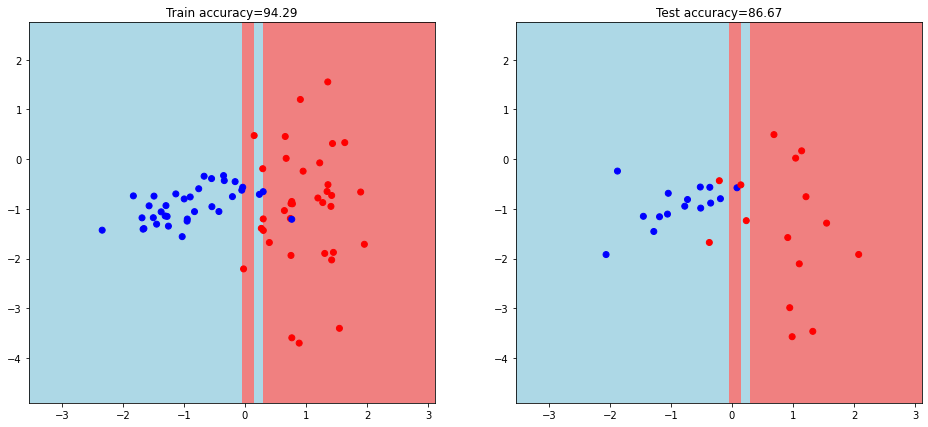

In [280]:
visualize(train_data, test_data, my_forest_1)

#### Лес из 3 деревьев

In [267]:
%%time
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

CPU times: user 14.5 ms, sys: 2.39 ms, total: 16.9 ms
Wall time: 15.4 ms


[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

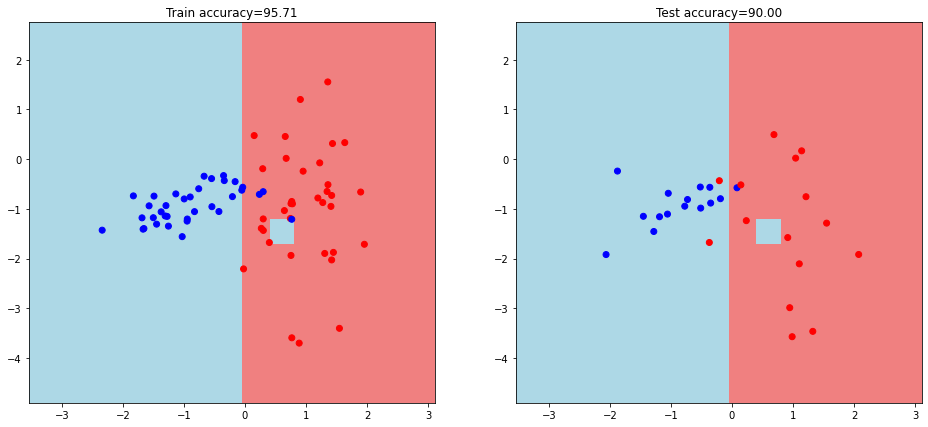

In [268]:
visualize(train_data, test_data, my_forest_3)

#### Лес из 10 деревьев

In [269]:
%%time
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

CPU times: user 41.1 ms, sys: 2.32 ms, total: 43.4 ms
Wall time: 41.6 ms


[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

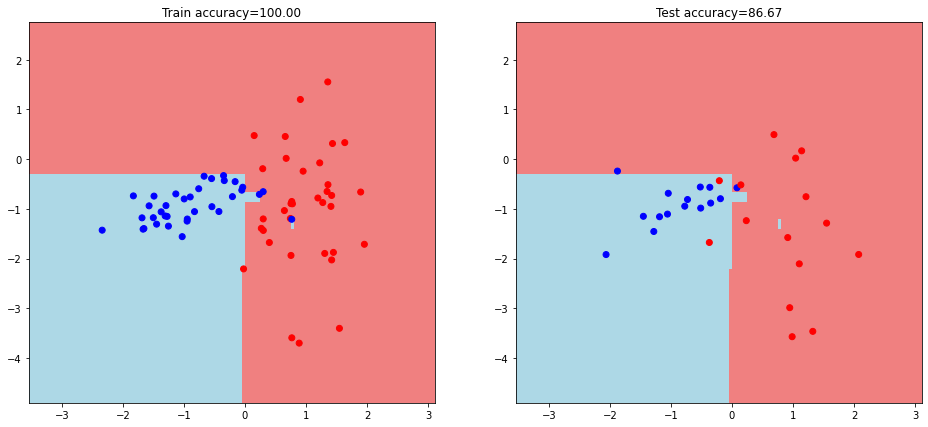

In [270]:
visualize(train_data, test_data, my_forest_10)

#### Лес из 50 деревьев

In [271]:
%%time
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

CPU times: user 208 ms, sys: 4.01 ms, total: 212 ms
Wall time: 213 ms


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



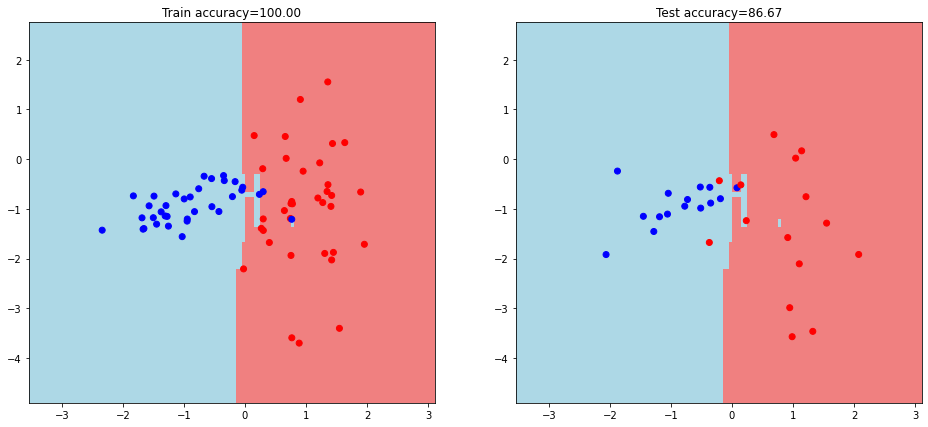

In [272]:
visualize(train_data, test_data, my_forest_50)

### Задание 2
Сделайте выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нём.

По графикам можно заметить, что чем больше деревьев входят в ансамбль, тем сложнее получается гиперплоскость. Важно подобрать оптимальное количество деревьев, так как если взять слишком много, то получим переобучение. А если мало - недообучение.

### Задание 3
Замените в реализованном алгоритме проверку, используя отложенную выборку на Out-of-Bag.

In [273]:
np.random.seed(42)

def get_oob(sample_ind):
    ind = np.arange(len(sample_ind))
    return ind[~np.isin(ind, sample_ind)]

def get_bootstrap_oob(data, labels, N):
    n_samples = data.shape[0] #совпадает с исходной выборкой
    bootstrap_oob = []
    
    for i in range(N):
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        oob_ind = get_oob(sample_index)
        
        bootstrap_oob.append((b_data, b_labels, oob_ind))
    return bootstrap_oob

In [274]:
get_bootstrap_oob(classification_data, classification_labels, 2)

[(array([[-0.37124564, -1.67679697],
         [-0.51278018, -0.98556015],
         [-0.54813278, -0.39241207],
         [-0.94885569, -1.24713565],
         [ 0.1502772 ,  0.47273166],
         [ 0.39895961, -1.67752215],
         [ 2.07599128, -1.91770526],
         [ 0.7432376 , -1.19378765],
         [ 1.63478531,  0.33127428],
         [ 1.63478531,  0.33127428],
         [ 0.2357014 , -0.70960755],
         [-1.50248523, -1.17842831],
         [ 0.29776211, -0.65527205],
         [ 0.23440873, -1.23792282],
         [ 0.75356225, -1.93718584],
         [ 1.5505173 , -1.28773359],
         [ 0.75362536, -0.89523588],
         [ 0.2357014 , -0.70960755],
         [-0.42752956, -1.05442826],
         [ 1.40819172, -0.95107001],
         [ 0.75362536, -0.89523588],
         [-1.57180854, -0.93984594],
         [ 0.67432897,  0.01459861],
         [ 0.39895961, -1.67752215],
         [-0.363129  , -0.56729178],
         [ 0.76616762, -0.85256618],
         [ 1.19398453, -0.7826786 ],
 

In [275]:
def predict_oob(oob_predictions, oob_ind, tree, data):
    oob_data = data[oob_ind]
    prediction = predict(oob_data, tree)
    
    for i in range(len(oob_ind)):
        oob_predictions[oob_ind[i], prediction[i]] += 1
    return oob_predictions

    
def random_forest_oob(data, labels, n_trees):
    forest = []
    oob_predictions = np.zeros((data.shape[0], len(set(labels))))
    bootstrap = get_bootstrap_oob(data, labels, n_trees)
    
    for b_data, b_labels, oob_ind in bootstrap:
        tree = build_tree(b_data, b_labels)
        forest.append(tree)
        
        oob_predictions = predict_oob(oob_predictions=oob_predictions,
                                      oob_ind=oob_ind,
                                      tree=tree,
                                      data=data)
#     print(oob_predictions)
    oob_score = accuracy_metric(labels, np.argmax(oob_predictions, axis=1))
    
    return forest, oob_score

In [276]:
forest, oob_score = random_forest_oob(classification_data, classification_labels, 3)
oob_score

77.0

### Задание 4
(На повторение) Перепишите функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шеннона. Переименуйте функцию в calc_entropy.

In [ ]:
def calc_entropy(labels):
    #  подсчет количества объектов разных классов
    classes={}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label]+=1
        
    # расчет энтропии Шеннона:
    summa = 0
    for label in classes:
        p = classes[label] / len(labels)
        summa += (p*np.log2(p))
    return -summa